# Mollow triplets

Test out the Fock hierarchy to compare with the squeezed hierarchy.

In [1]:
from functools import partial
import pdb

import pickle
import numpy as np
from scipy.fftpack import fft
from scipy.integrate import quad
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [4]:
plt.style.use('paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
Rabi frequency $\Omega=2|\beta|$. Carmichæl notates the Rabi frequency as $2\Omega$, so $\Omega=|\beta|$.

In [5]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [6]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [7]:
quad(lambda t: xi_rect(t, a=0, b=2)**2, -1, 3)

In [8]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

def calc_hier_state_evo(xi_fn, L, r, mu, beta, gamma, m_max, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    return soln_t

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, gamma, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus, solve_ivp_kwargs=None):
    N = np.sinh(r)**2
    M_sq = -np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(np.sqrt(gamma)*L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    #pdb.set_trace()

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    #pdb.set_trace()

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    #pdb.set_trace()

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)

    #pdb.set_trace()
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

def calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(
        Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
    integrator = integ.QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [9]:
def plot_emission_spectra(auto_corrs, labels, Rabi_offset, kwargs_plots=None, width=50, ax=None, figsize=(10,3), broadband=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_fig = True
    else:
        return_fig = False
    if kwargs_plots is None:
        kwargs_plots = it.repeat({}, len(auto_corrs))
    for auto_corr, label, kwargs in zip(auto_corrs, labels, kwargs_plots):
        ywf = fft(auto_corr.real)
        ax.plot(np.abs(np.hstack([ywf[-width:], ywf[:width]])), label=label, **kwargs)
    ax.legend()
    ax.set_xticks([width - Rabi_offset, width, width + Rabi_offset])
    ax.set_xticklabels([r'$\omega_c-\Omega$', r'$\omega_c$', r'$\omega_c+\Omega$'])
    ax.set_yticks([])
    ax.set_ylim(0, None)
    ax.set_ylabel(r'$S(\omega)$')
    ax.set_xlabel(r'$\omega$')
    return (fig, ax) if return_fig else None

In [10]:
def lam_mu(gamma_c, eps):
    lam = gamma_c + eps
    mu = gamma_c - eps
    return lam, mu

def N_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               - 1/((omega - omega_A)**2 + lam**2))
    
def mod_M_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               + 1/((omega - omega_A)**2 + lam**2))

def deltas_degen_PA(gamma_c, Omega, lam, mu):
    delta_mu = gamma_c*Omega*(lam**2 - mu**2)/(4*mu*(Omega**2 + mu**2))
    delta_lam = gamma_c*Omega*(lam**2 - mu**2)/(4*lam*(Omega**2 + mu**2))
    return delta_mu, delta_lam

def F_G(delta_mu, delta_lam, Phi):
    F_A = -(1j/4)*(delta_mu*(1 + np.cos(Phi))
                   - delta_lam*(1 - np.cos(Phi)))
    G_A = -(1/4)*(delta_mu + delta_lam)*np.sin(Phi)
    return F_A, G_A

def get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
    lam, mu = lam_mu(gamma_c, eps)
    N_A = N_degen_PA(omega_A, omega_A, lam, mu)
    N_Om = N_degen_PA(omega_A + Omega, omega_A, lam, mu)
    mod_M_A = mod_M_degen_PA(omega_A, omega_A, lam, mu)
    mod_M_Om = mod_M_degen_PA(omega_A + Omega, omega_A, lam, mu)
    M_A = np.exp(2j*phi_s)*mod_M_A
    M_Om = np.exp(2j*phi_s)*mod_M_Om
    Delta_AL = omega_A - omega_L
    Phi = 2*phi_L - phi_s
    delta_mu, delta_lam = deltas_degen_PA(gamma_c, Omega, lam, mu)
    F_A, G_A = F_G(delta_mu, delta_lam, Phi)
    return N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

In [11]:
rho0 = (Id - sz) / 2
S = Id
L = sm
H = zero

In [12]:
gamma = 0.5
beta = 4.j
T = 2**10
width = 2*T
taus = np.linspace(0, T, 2**14)
times_ss = np.linspace(0, 32, 2**12)
d_omega = 2*np.pi / T
Rabi_offset = 2*np.abs(beta) // d_omega

In [13]:
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, gamma, beta, 0, 0, times_ss, taus,
                                                         solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

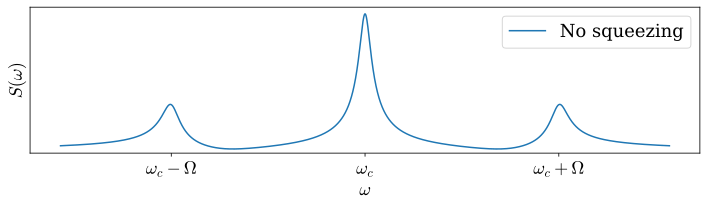

In [14]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh], ['No squeezing'], Rabi_offset, width=width)
plt.tight_layout()

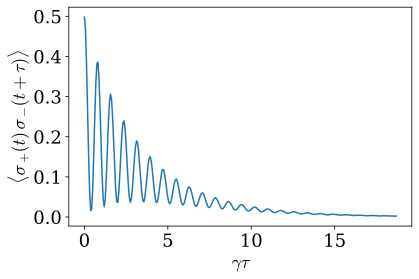

In [15]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(delta_Expt_t_taus_coh))
tf_idx = 300
ax.plot(times[:tf_idx], delta_Expt_t_taus_coh[:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [16]:
r = np.log(2)
mu = 0
rho_ss_sq, delta_Expt_t_taus_sq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus,
                                                       solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

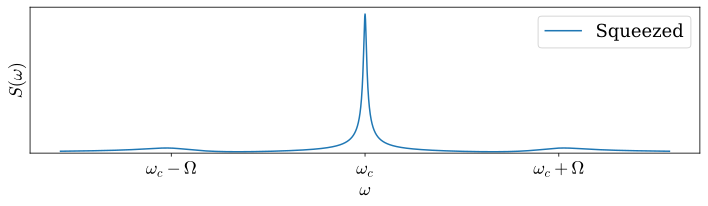

In [17]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_sq], ['Squeezed'], Rabi_offset, width=width)
plt.tight_layout()

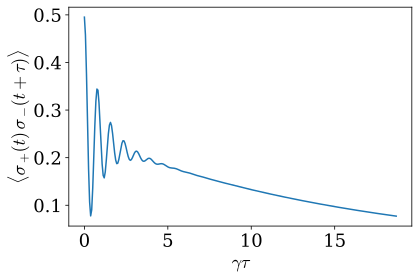

In [18]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(delta_Expt_t_taus_sq))
tf_idx = 300
ax.plot(times[:tf_idx], delta_Expt_t_taus_sq[:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [19]:
r = np.log(2)
mu = np.pi/2
rho_ss_antisq, delta_Expt_t_taus_antisq = calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus,
                                                               solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

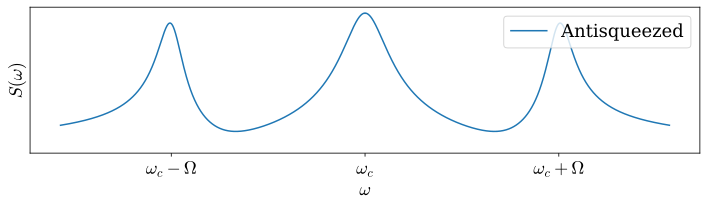

In [20]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_antisq], ['Antisqueezed'], Rabi_offset, width=width)
plt.tight_layout()

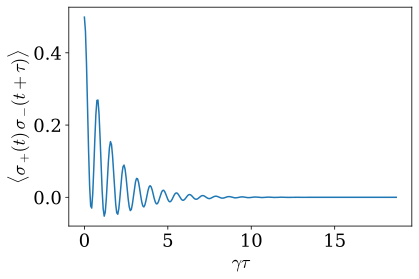

In [21]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(delta_Expt_t_taus_antisq))
tf_idx = 300
ax.plot(times[:tf_idx], delta_Expt_t_taus_antisq[:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [22]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
omega_A = 0
omega_L = 0
gamma_c = 1
eps = 0.5
phi_s = 0
rho_ss_qm, delta_Expt_t_taus_qm = calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

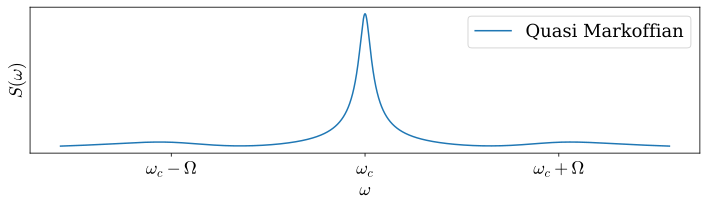

In [23]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_qm], ['Quasi Markoffian'], Rabi_offset, width=width)
plt.tight_layout()

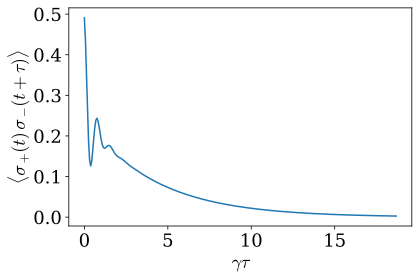

In [24]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(delta_Expt_t_taus_qm))
tf_idx = 300
ax.plot(times[:tf_idx], delta_Expt_t_taus_qm[:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [25]:
Omega = 2*np.abs(beta)
phi_L = np.angle(beta)
omega_A = 0
omega_L = 0
gamma_c = 1
eps = 0.5
phi_s = np.pi/2
rho_ss_qm_anti, delta_Expt_t_taus_qm_anti = calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

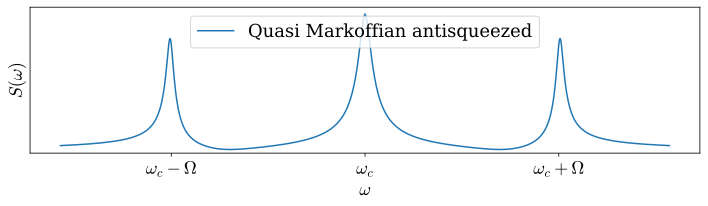

In [26]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_qm_anti], ['Quasi Markoffian antisqueezed'], Rabi_offset, width=width)
plt.tight_layout()

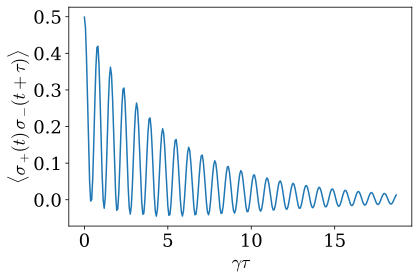

In [27]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(delta_Expt_t_taus_qm_anti))
tf_idx = 300
ax.plot(times[:tf_idx], delta_Expt_t_taus_qm_anti[:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [28]:
def gen_save_load_data(data_gen_method, fname, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method()
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [29]:
def gen_Expt_t_taus_wavepacket(L, r, mu, beta, gamma, m_max, taus, rho_ss_coh, t_final, solve_ivp_kwargs=None):
    return calc_hier_auto_corr(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                               L, r, mu, beta, gamma, m_max,
                               taus, rho_ss_coh, t=t_final,
                               solve_ivp_kwargs=solve_ivp_kwargs)

In [30]:
r = np.log(2)
mu = 0
m_max = 12
t_final = 0.5
Expt_t_taus_wavepacket = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                    gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                    t_final=t_final, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                            'Expt_t_taus_wavepacket.pickle')

Data already exist.


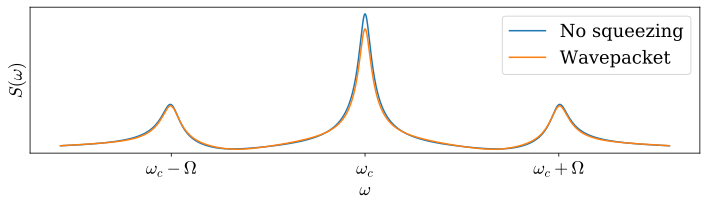

In [31]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket[0]],
                                ['No squeezing',
                                 'Wavepacket'],
                                Rabi_offset, width=width)
plt.tight_layout()

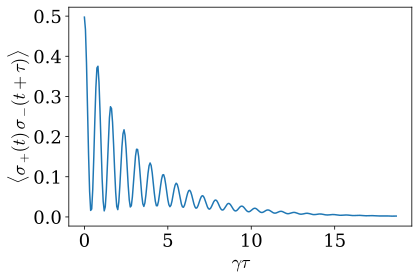

In [32]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(Expt_t_taus_wavepacket[0]))
tf_idx = 300
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket[0][:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
plt.tight_layout()

In [33]:
r = np.log(2)
mu = 0
m_max = 12
t_final = 0.75
Expt_t_taus_wavepacket_075 = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                        gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                        t_final=t_final, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                                'Expt_t_taus_wavepacket_075.pickle')

Data already exist.


In [34]:
r = np.log(2)
mu = 0
m_max = 12
t_final = 0.25
Expt_t_taus_wavepacket_025 = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                        gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                        t_final=t_final, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                                'Expt_t_taus_wavepacket_025.pickle')

Data already exist.


In [35]:
r = np.log(2)
mu = 0
m_max = 12
t_final = 1.0
Expt_t_taus_wavepacket_100 = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                        gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                        t_final=t_final, solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                                'Expt_t_taus_wavepacket_100.pickle')

Data already exist.


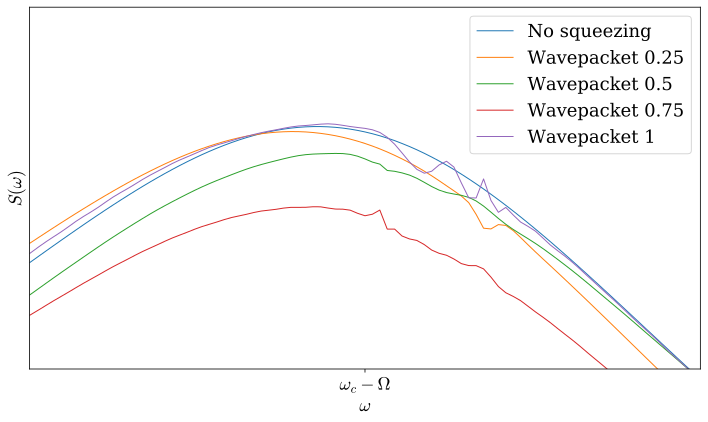

In [36]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_025[0],
                                 Expt_t_taus_wavepacket[0],
                                 Expt_t_taus_wavepacket_075[0],
                                 Expt_t_taus_wavepacket_100[0]],
                                ['No squeezing',
                                 'Wavepacket 0.25',
                                 'Wavepacket 0.5',
                                 'Wavepacket 0.75',
                                 'Wavepacket 1'],
                                Rabi_offset, width=width,
                                kwargs_plots=it.repeat({'linewidth': 1}),
                                figsize=(10, 6))
ax.set_xlim(width - Rabi_offset - np.sqrt(width), width - Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()

In [37]:
r = np.log(2)
mu = 0
m_max = 12
t_final = 1.0
solve_ivp_kwargs = {'rtol': 1e-9, 'atol': 1e-12}
Expt_t_taus_wavepacket_100_tol = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                            gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                            t_final=t_final, solve_ivp_kwargs=solve_ivp_kwargs),
                                                    'Expt_t_taus_wavepacket_100_tol.pickle')

Data already exist.


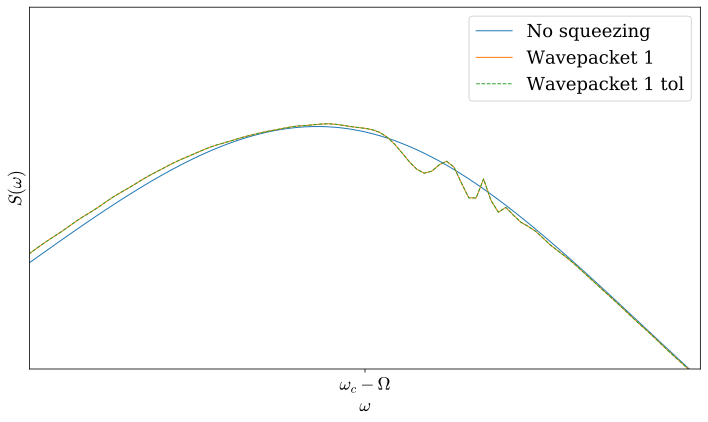

In [38]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_100[0],
                                 Expt_t_taus_wavepacket_100_tol[0]],
                                ['No squeezing',
                                 'Wavepacket 1',
                                 'Wavepacket 1 tol'],
                                Rabi_offset, width=width,
                                kwargs_plots=[{'linewidth': 1}, {'linewidth': 1},
                                              {'linewidth': 1, 'linestyle': '--'}],
                                figsize=(10, 6))
ax.set_xlim(width - Rabi_offset - np.sqrt(width), width - Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()

In [39]:
r = np.log(2)
mu = 0
m_max = 13
t_final = 1.0
solve_ivp_kwargs = {'rtol': 1e-6, 'atol': 1e-9}
Expt_t_taus_wavepacket_100_m_13 = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                             gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                             t_final=t_final, solve_ivp_kwargs=solve_ivp_kwargs),
                                                     'Expt_t_taus_wavepacket_100_m_13.pickle')

Data already exist.


In [40]:
r = np.log(2)
mu = 0
m_max = 14
t_final = 1.0
solve_ivp_kwargs = {'rtol': 1e-6, 'atol': 1e-9}
Expt_t_taus_wavepacket_100_m_14 = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, L=L, r=r, mu=mu, beta=beta,
                                                             gamma=gamma, m_max=m_max, taus=taus, rho_ss_coh=rho_ss_coh,
                                                             t_final=t_final, solve_ivp_kwargs=solve_ivp_kwargs),
                                                     'Expt_t_taus_wavepacket_100_m_14.pickle')

Data already exist.


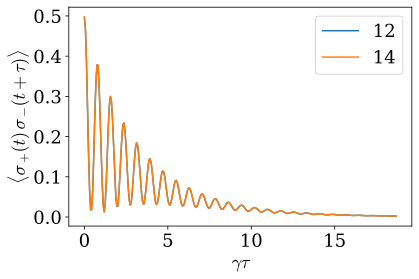

In [41]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(Expt_t_taus_wavepacket_100_m_14[0]))
tf_idx = 300
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket_100[0][:tf_idx].real, label='12')
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real, label='14')
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
ax.legend()
plt.tight_layout()

In [42]:
r = np.log(2)
mu = 0
m_max = 14
t_final = 3
solve_ivp_kwargs = {'rtol': 1e-6, 'atol': 1e-9}
solns_wavepacket_100_m_14 = calc_hier_state_evo(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                L, r, mu, beta, gamma, m_max,
                                                rho_ss_coh, t=t_final,
                                                solve_ivp_kwargs=solve_ivp_kwargs)

In [43]:
r = np.log(2)
mu = 0
m_max = 14
t_final = 3
solve_ivp_kwargs = {'rtol': 1e-6, 'atol': 1e-9, 'method': 'BDF'}
solns_wavepacket_100_m_14_tol = calc_hier_state_evo(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                    L, r, mu, beta, gamma, m_max,
                                                    rho_ss_coh, t=t_final,
                                                    solve_ivp_kwargs=solve_ivp_kwargs)

In [44]:
r = np.log(2)
mu = 0
m_max = 13
t_final = 3
solve_ivp_kwargs = {'rtol': 1e-6, 'atol': 1e-9}
solns_wavepacket_100_m_13 = calc_hier_state_evo(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                                L, r, mu, beta, gamma, m_max,
                                                rho_ss_coh, t=t_final,
                                                solve_ivp_kwargs=solve_ivp_kwargs)

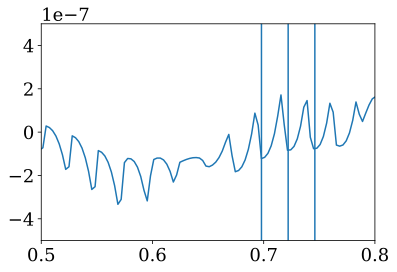

In [45]:
z_vals_13 = solns_wavepacket_100_m_13.get_expectations(sz, rho_from_ket(np.array([1] + 13*[0])))
z_vals_14 = solns_wavepacket_100_m_14.get_expectations(sz, rho_from_ket(np.array([1] + 14*[0])))
times = np.linspace(0, t_final, len(z_vals_13))
plt.plot(times, z_vals_13 - z_vals_14)
plt.xlim(0.5, 0.8)
plt.ylim(-0.0000005, 0.0000005)
w = 0.024
plt.axvline(0.698)
plt.axvline(0.698 + w)
plt.axvline(0.698 + 2*w)

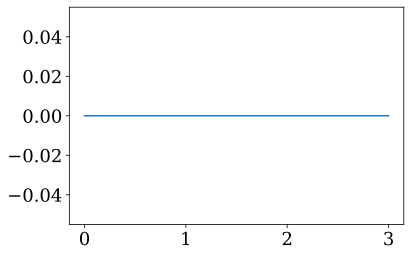

In [46]:
z_vals_14_tol = solns_wavepacket_100_m_14_tol.get_expectations(sz, rho_from_ket(np.array([1] + 14*[0])))
z_vals_14 = solns_wavepacket_100_m_14.get_expectations(sz, rho_from_ket(np.array([1] + 14*[0])))
times = np.linspace(0, t_final, len(z_vals_13))
plt.plot(times, z_vals_14_tol - z_vals_14)
#plt.xlim(0.5, 0.8)
#plt.ylim(-0.0000005, 0.0000005)
#w = 0.024
#plt.axvline(0.698)
#plt.axvline(0.698 + w)
#plt.axvline(0.698 + 2*w)

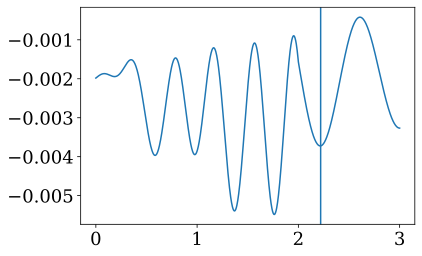

In [47]:
times = np.linspace(0, t_final, len(z_vals_13))
plt.plot(times, z_vals_13)
#plt.xlim(0.5, 0.8)
#plt.ylim(-0.0000005, 0.0000005)
#w = 0.024
plt.axvline(2.22)
#plt.axvline(0.698 + w)
#plt.axvline(0.698 + 2*w)

In [48]:
1/w

In [49]:
1/(3-2.22)

In [50]:
(3-2.22)/w

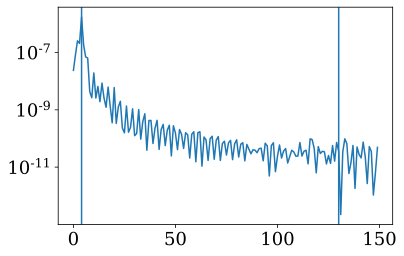

In [51]:
plt.semilogy(np.abs(fft(z_vals_13 - z_vals_14)[:150])**2)
plt.axvline(4)
plt.axvline(4*32.5)

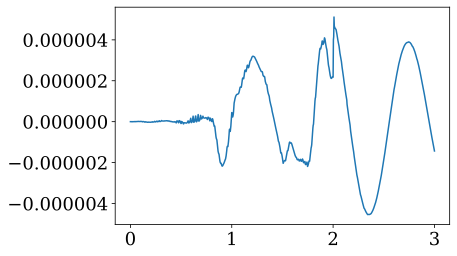

In [52]:
plt.plot(times, solns_wavepacket_100_m_13.get_expectations(sy, rho_from_ket(np.array([1] + 13*[0])))
         - solns_wavepacket_100_m_14.get_expectations(sy, rho_from_ket(np.array([1] + 14*[0]))))

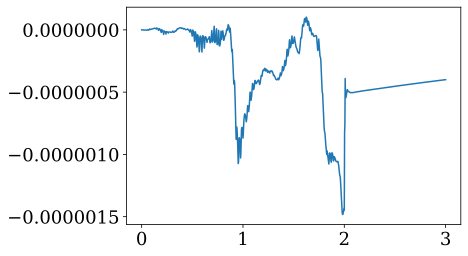

In [53]:
plt.plot(times, solns_wavepacket_100_m_13.get_expectations(sx, rho_from_ket(np.array([1] + 13*[0])))
         - solns_wavepacket_100_m_14.get_expectations(sx, rho_from_ket(np.array([1] + 14*[0]))))

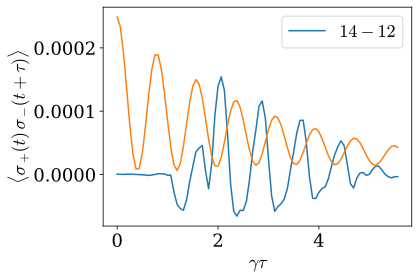

In [54]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(Expt_t_taus_wavepacket_100_m_14[0]))
tf_idx = 90
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real - Expt_t_taus_wavepacket_100[0][:tf_idx].real,
        label='$14-12$')
ax.plot(times[:tf_idx], 5e-4*Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
ax.legend()
plt.tight_layout()

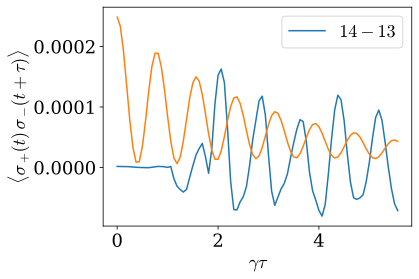

In [55]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(Expt_t_taus_wavepacket_100_m_14[0]))
tf_idx = 90
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real - Expt_t_taus_wavepacket_100_m_13[0][:tf_idx].real,
        label='$14-13$')
ax.plot(times[:tf_idx], 5e-4*Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
ax.legend()
plt.tight_layout()

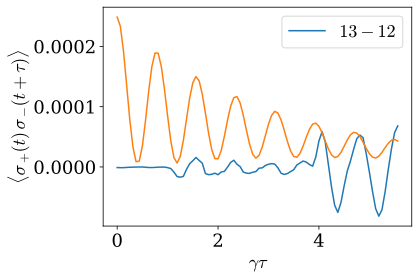

In [56]:
fig, ax = plt.subplots()
times = np.linspace(0, T, len(Expt_t_taus_wavepacket_100_m_14[0]))
tf_idx = 90
ax.plot(times[:tf_idx], Expt_t_taus_wavepacket_100_m_13[0][:tf_idx].real - Expt_t_taus_wavepacket_100[0][:tf_idx].real,
        label='$13-12$')
ax.plot(times[:tf_idx], 5e-4*Expt_t_taus_wavepacket_100_m_14[0][:tf_idx].real)
ax.set_xlabel(r'$\gamma\tau$')
ax.set_ylabel(r'$\langle\sigma_+\!(t)\,\sigma_-\!(t+\tau)\rangle$')
ax.legend()
plt.tight_layout()

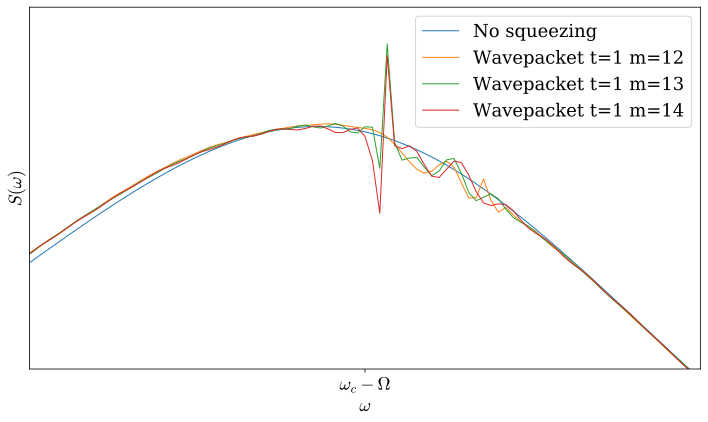

In [57]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_100[0],
                                 Expt_t_taus_wavepacket_100_m_13[0],
                                 Expt_t_taus_wavepacket_100_m_14[0]],
                                ['No squeezing',
                                 'Wavepacket t=1 m=12',
                                 'Wavepacket t=1 m=13',
                                 'Wavepacket t=1 m=14'],
                                Rabi_offset, width=width,
                                kwargs_plots=it.repeat({'linewidth': 1}),
                                figsize=(10, 6))
ax.set_xlim(width - Rabi_offset - np.sqrt(width), width - Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()

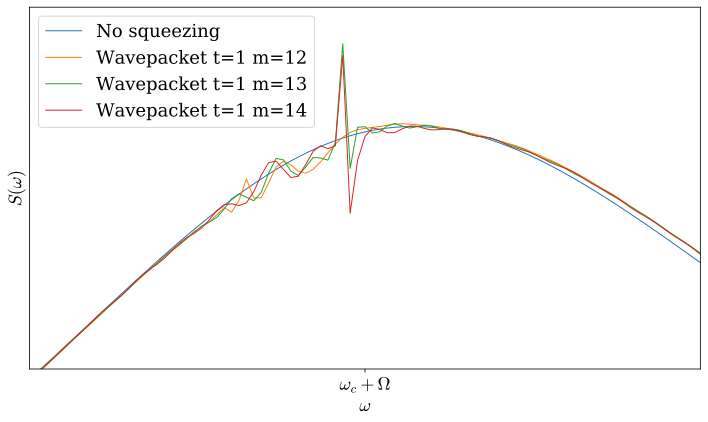

In [58]:
fig, ax = plot_emission_spectra([delta_Expt_t_taus_coh,
                                 Expt_t_taus_wavepacket_100[0],
                                 Expt_t_taus_wavepacket_100_m_13[0],
                                 Expt_t_taus_wavepacket_100_m_14[0]],
                                ['No squeezing',
                                 'Wavepacket t=1 m=12',
                                 'Wavepacket t=1 m=13',
                                 'Wavepacket t=1 m=14'],
                                Rabi_offset, width=width,
                                kwargs_plots=it.repeat({'linewidth': 1}),
                                figsize=(10, 6))
ax.set_xlim(width + Rabi_offset - np.sqrt(width), width + Rabi_offset + np.sqrt(width))
ax.set_ylim(ax.get_ylim()[1]/4, 3*ax.get_ylim()[1]/8)
plt.tight_layout()